<a href="https://colab.research.google.com/github/Fedor102/RAG-system/blob/main/RAG_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Загружаем книгу в pdf "Мастер и Маргарита"

In [ ]:
import requests
# Ваша ссылка на книгу
url = 'https://www.phantastike.com/classic/master_i_margarita/pdf/'

In [ ]:
# Запрос на скачивание
response = requests.get(url)

# Сохранение файла
with open('book.pdf', 'wb') as f:
    f.write(response.content)

In [ ]:
# Проверка, что файл скачался
print("Файл скачан")

Файл скачан


#Строим RAG-систему

###Устанавливаем и импортируем библиотеки определённых версий, потому что возникает конфликт зависимостей.

In [ ]:
!pip install openai llama_index "arize-phoenix[evals,llama-index]" gcsfs nest-asyncio "openinference-instrumentation-llama-index>=2.0.0" llama-index-core==0.10.43

  Using cached llama_index_core-0.10.43-py3-none-any.whl.metadata (2.4 kB)
INFO: pip is looking at multiple versions of llama-index to determine which version is compatible with other requirements. This could take a while.
  Using cached llama_index-0.11.10-py3-none-any.whl.metadata (11 kB)
  Using cached llama_index-0.11.9-py3-none-any.whl.metadata (11 kB)
  Using cached llama_index-0.11.8-py3-none-any.whl.metadata (11 kB)
  Using cached llama_index-0.11.7-py3-none-any.whl.metadata (11 kB)
  Using cached llama_index-0.11.6-py3-none-any.whl.metadata (11 kB)
  Using cached llama_index-0.11.5-py3-none-any.whl.metadata (11 kB)
  Using cached llama_index-0.11.4-py3-none-any.whl.metadata (11 kB)
INFO: pip is still looking at multiple versions of llama-index to determine which version is compatible with other requirements. This could take a while.
  Using cached llama_index-0.11.3-py3-none-any.whl.metadata (11 kB)
  Using cached llama_index-0.11.2-py3-none-any.whl.metadata (11 kB)
  Using ca

In [ ]:
!pip install --upgrade llama-index

  Using cached llama_index-0.11.11-py3-none-any.whl.metadata (11 kB)
  Using cached llama_index_agent_openai-0.3.4-py3-none-any.whl.metadata (728 bytes)
  Using cached llama_index_cli-0.3.1-py3-none-any.whl.metadata (1.5 kB)
  Using cached llama_index_core-0.11.11-py3-none-any.whl.metadata (2.4 kB)
  Using cached llama_index_embeddings_openai-0.2.5-py3-none-any.whl.metadata (686 bytes)
  Using cached llama_index_indices_managed_llama_cloud-0.3.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached llama_index_llms_openai-0.2.9-py3-none-any.whl.metadata (648 bytes)
  Using cached llama_index_multi_modal_llms_openai-0.2.1-py3-none-any.whl.metadata (728 bytes)
  Using cached llama_index_program_openai-0.2.0-py3-none-any.whl.metadata (766 bytes)
  Using cached llama_index_question_gen_openai-0.2.0-py3-none-any.whl.metadata (785 bytes)
  Using cached llama_index_readers_file-0.2.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached llama_index_readers_llama_parse-0.3.0-py3-none-any.whl.metadata 

In [ ]:
!pip install --upgrade tenacity==8.2.0

In [ ]:
import getpass # для работы с паролями
import os      # для работы с окружением и файловой системой

# Запрос ввода ключа от OpenAI
os.environ["OPENAI_API_KEY"] = getpass.getpass("Введите OpenAI API Key:")

Введите OpenAI API Key:··········


In [ ]:
import openai
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding

from llama_index.core import (
    VectorStoreIndex,
    SimpleDirectoryReader,
    GPTVectorStoreIndex,
    download_loader,
    KeywordTableIndex,
    StorageContext,
    load_index_from_storage,
    ServiceContext,
    Settings,
)

In [ ]:
# Установим модель по умолчанию

Settings.llm = OpenAI(temperature=0, model='gpt-3.5-turbo')

In [ ]:
!pip install pymupdf

In [ ]:
# Загружаем PDFLoader для работы с PDF файлами
PDFReader = download_loader("PDFReader")

<ipython-input-48-52314ff90035>:2: DeprecationWarning: Call to deprecated function (or staticmethod) download_loader. (`download_loader()` is deprecated. Please install tool using pip install directly instead.)
  PDFReader = download_loader("PDFReader")


###Для постобработки используем расширенный поисковик из LlamaHub - PyMuPDF

In [ ]:
# Создаем объект загрузчика и читаем PDF
pdf_reader = PDFReader()
documents = pdf_reader.load_data(file='./book.pdf')

In [ ]:
# Выводим документ для проверки
print(documents[8].text[:500])

Михаил Булгаков: «Мастер и Маргарита»  9 
успел ра зглядеть на карточке напечатанное иностранными буквами слово «профессор » и 
начальную букву фамилии – двойное «В». 
 
– Очень приятно,  – тем временем смущенно борм отал редактор, и иностранец спрятал 
документы в карман.  
Отношения таким образом были восстановлены, и все трое снова сели на скамью.  
– Вы в качестве консультанта приглашены к нам, профессор?  – спросил Берлиоз.  
– Да, консультантом.  
– Вы – немец?  – осведомил ся Бездомный.  


In [ ]:
# Теперь создаем индекс для дальнейшей работы с ним
index = GPTVectorStoreIndex.from_documents(documents)

In [ ]:
# Подготавливаем движок к индексу и задем ему вопрос
query_engine = index.as_query_engine()

In [ ]:
# Можем выполнить запрос к индексу
response = query_engine.query("Как фамилия героя, которому голову на рельсах отрезало?")
print(response)

Берлиоз.


###Выполняем наблюдение с помощью инструмента Phoenix

In [ ]:
import nest_asyncio
import phoenix as px

from phoenix.evals import (
    HallucinationEvaluator,
    OpenAIModel,
    QAEvaluator,
    RelevanceEvaluator,
    run_evals,
)
from phoenix.session.evaluation import get_qa_with_reference, get_retrieved_documents
from phoenix.trace import DocumentEvaluations, SpanEvaluations

In [ ]:
nest_asyncio.apply()  # необходим для параллельных вычислений в среде ноутбуков

In [ ]:
session = px.launch_app()

WARNI [phoenix.session.session] Existing running Phoenix instance detected! Shutting it down and starting a new instance...


🌍 To view the Phoenix app in your browser, visit https://b5vj7qs605e11-496ff2e9c6d22116-6006-colab.googleusercontent.com/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [ ]:
from openinference.instrumentation.llama_index import LlamaIndexInstrumentor
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter
from opentelemetry.sdk.trace import TracerProvider
from opentelemetry.sdk.trace.export import SimpleSpanProcessor

endpoint = "http://127.0.0.1:6006/v1/traces"
tracer_provider = TracerProvider()
tracer_provider.add_span_processor(SimpleSpanProcessor(OTLPSpanExporter(endpoint)))

LlamaIndexInstrumentor().instrument(tracer_provider=tracer_provider)

WARNI [opentelemetry.instrumentation.instrumentor] Attempting to instrument while already instrumented


In [ ]:
try:
    LlamaIndexInstrumentor().instrument(tracer_provider=tracer_provider)
except Exception as e:
    print(f"Error during instrumentation: {e}")

WARNI [opentelemetry.instrumentation.instrumentor] Attempting to instrument while already instrumented


In [ ]:
Settings.llm = OpenAI(model="gpt-3.5-turbo")
Settings.embed_model = OpenAIEmbedding(model="text-embedding-ada-002")
index = GPTVectorStoreIndex.from_documents(
	documents
)
query_engine = index.as_query_engine()

In [ ]:
response = query_engine.query("Как фамилия героя, которому голову на рельсах отрезало?")
print(response)

Берлиоз.


In [ ]:
print(f"🚀 Открой Phoenix UI для просмотра результата трассировки по ссылке: {session.url}")

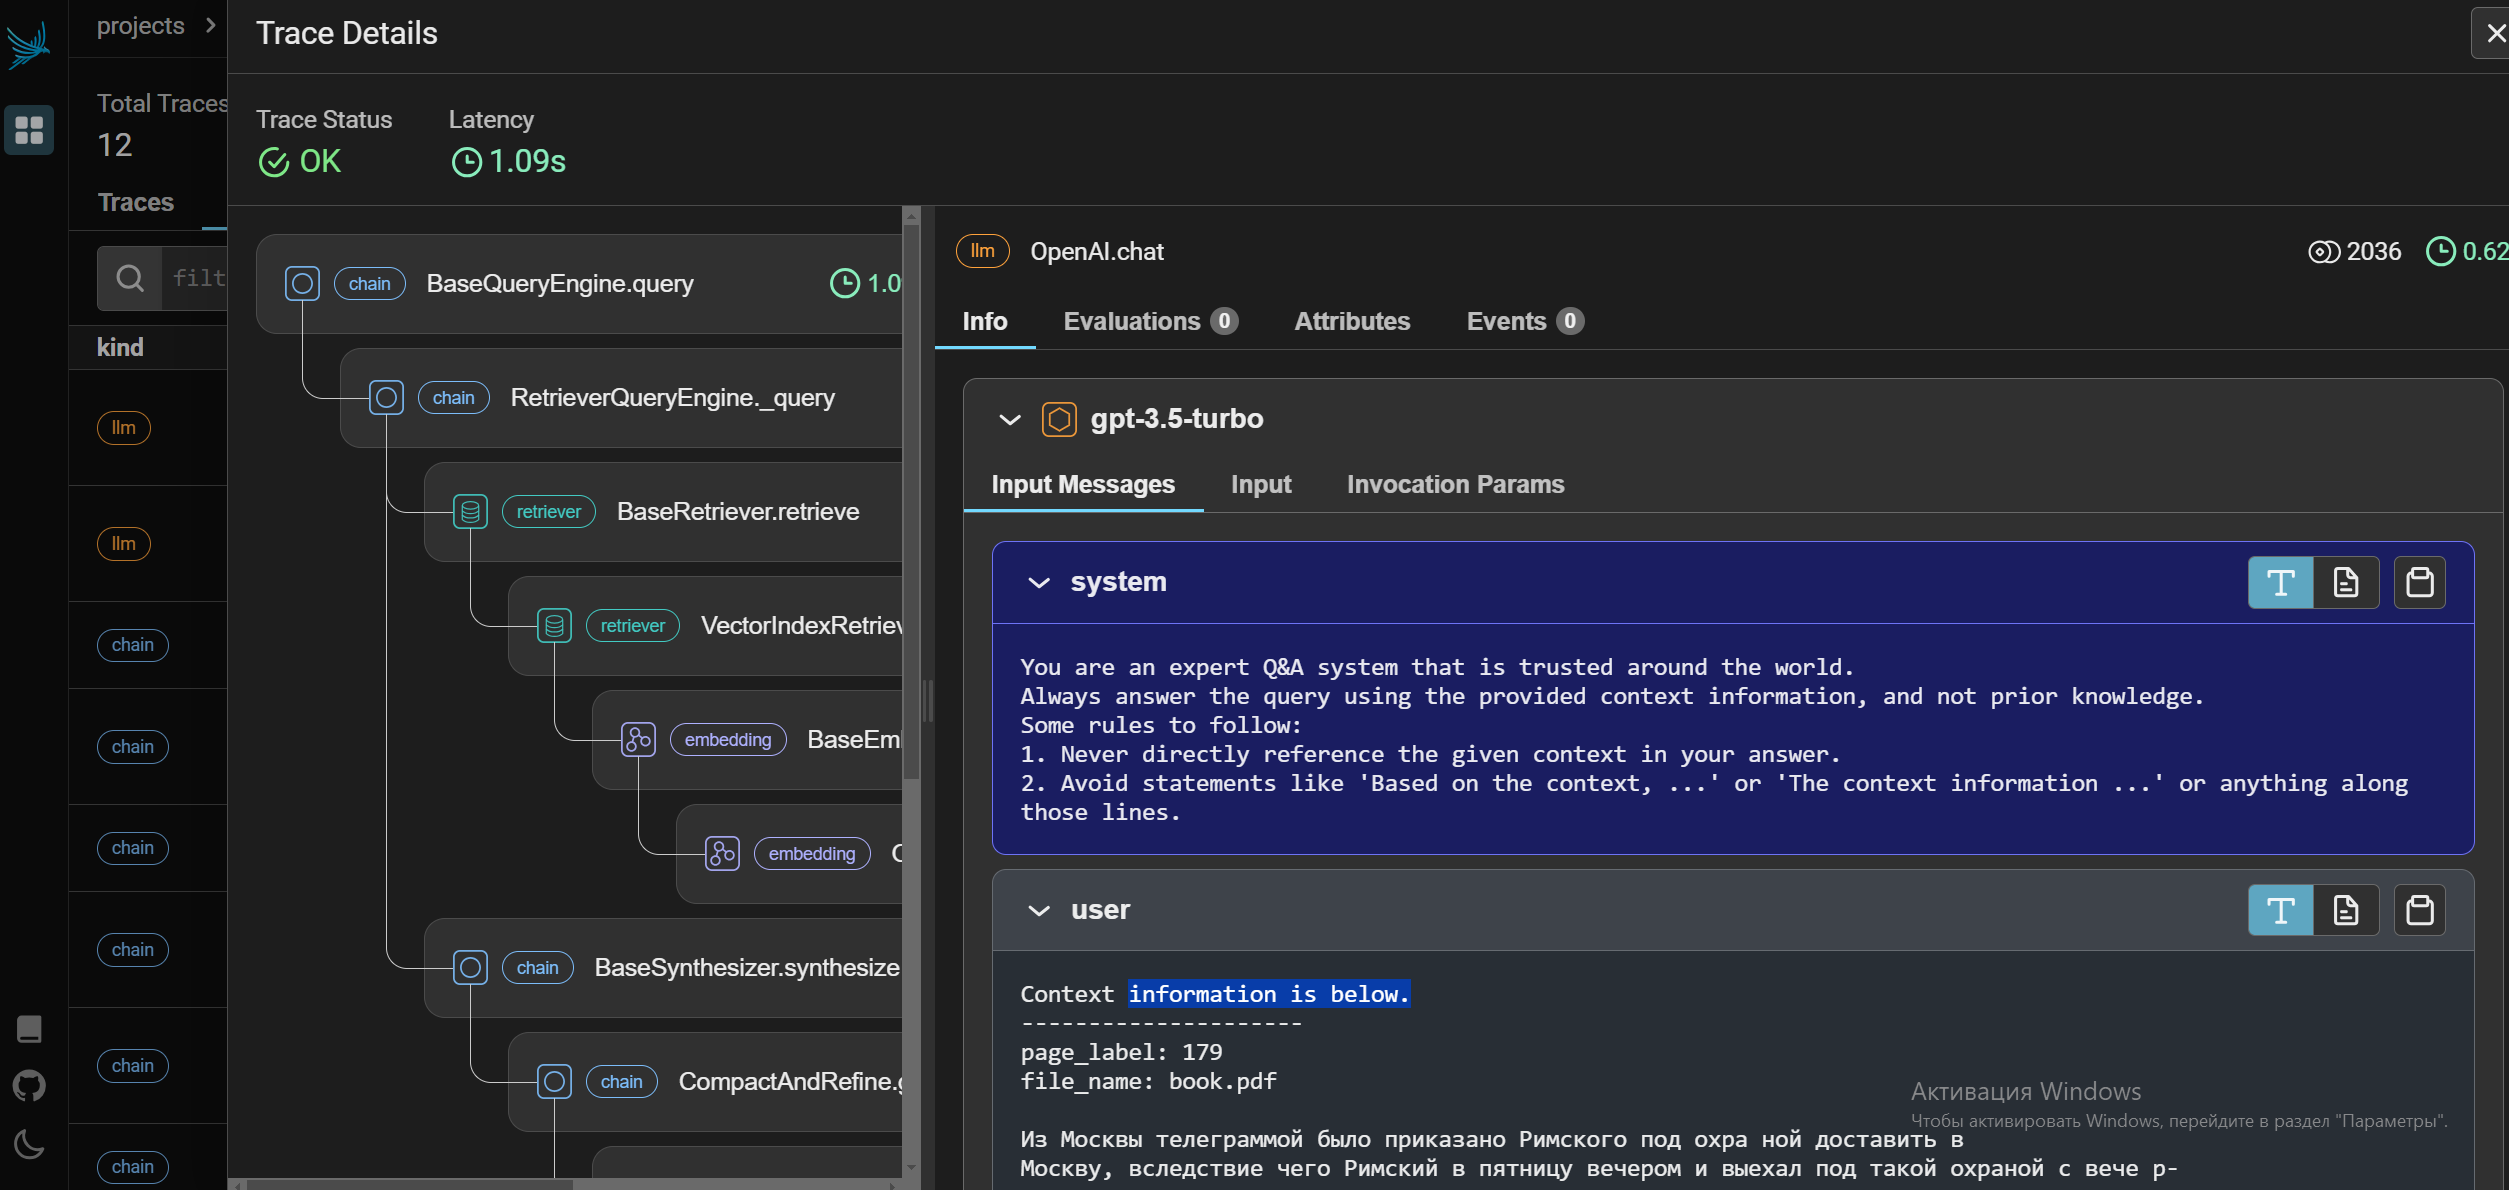

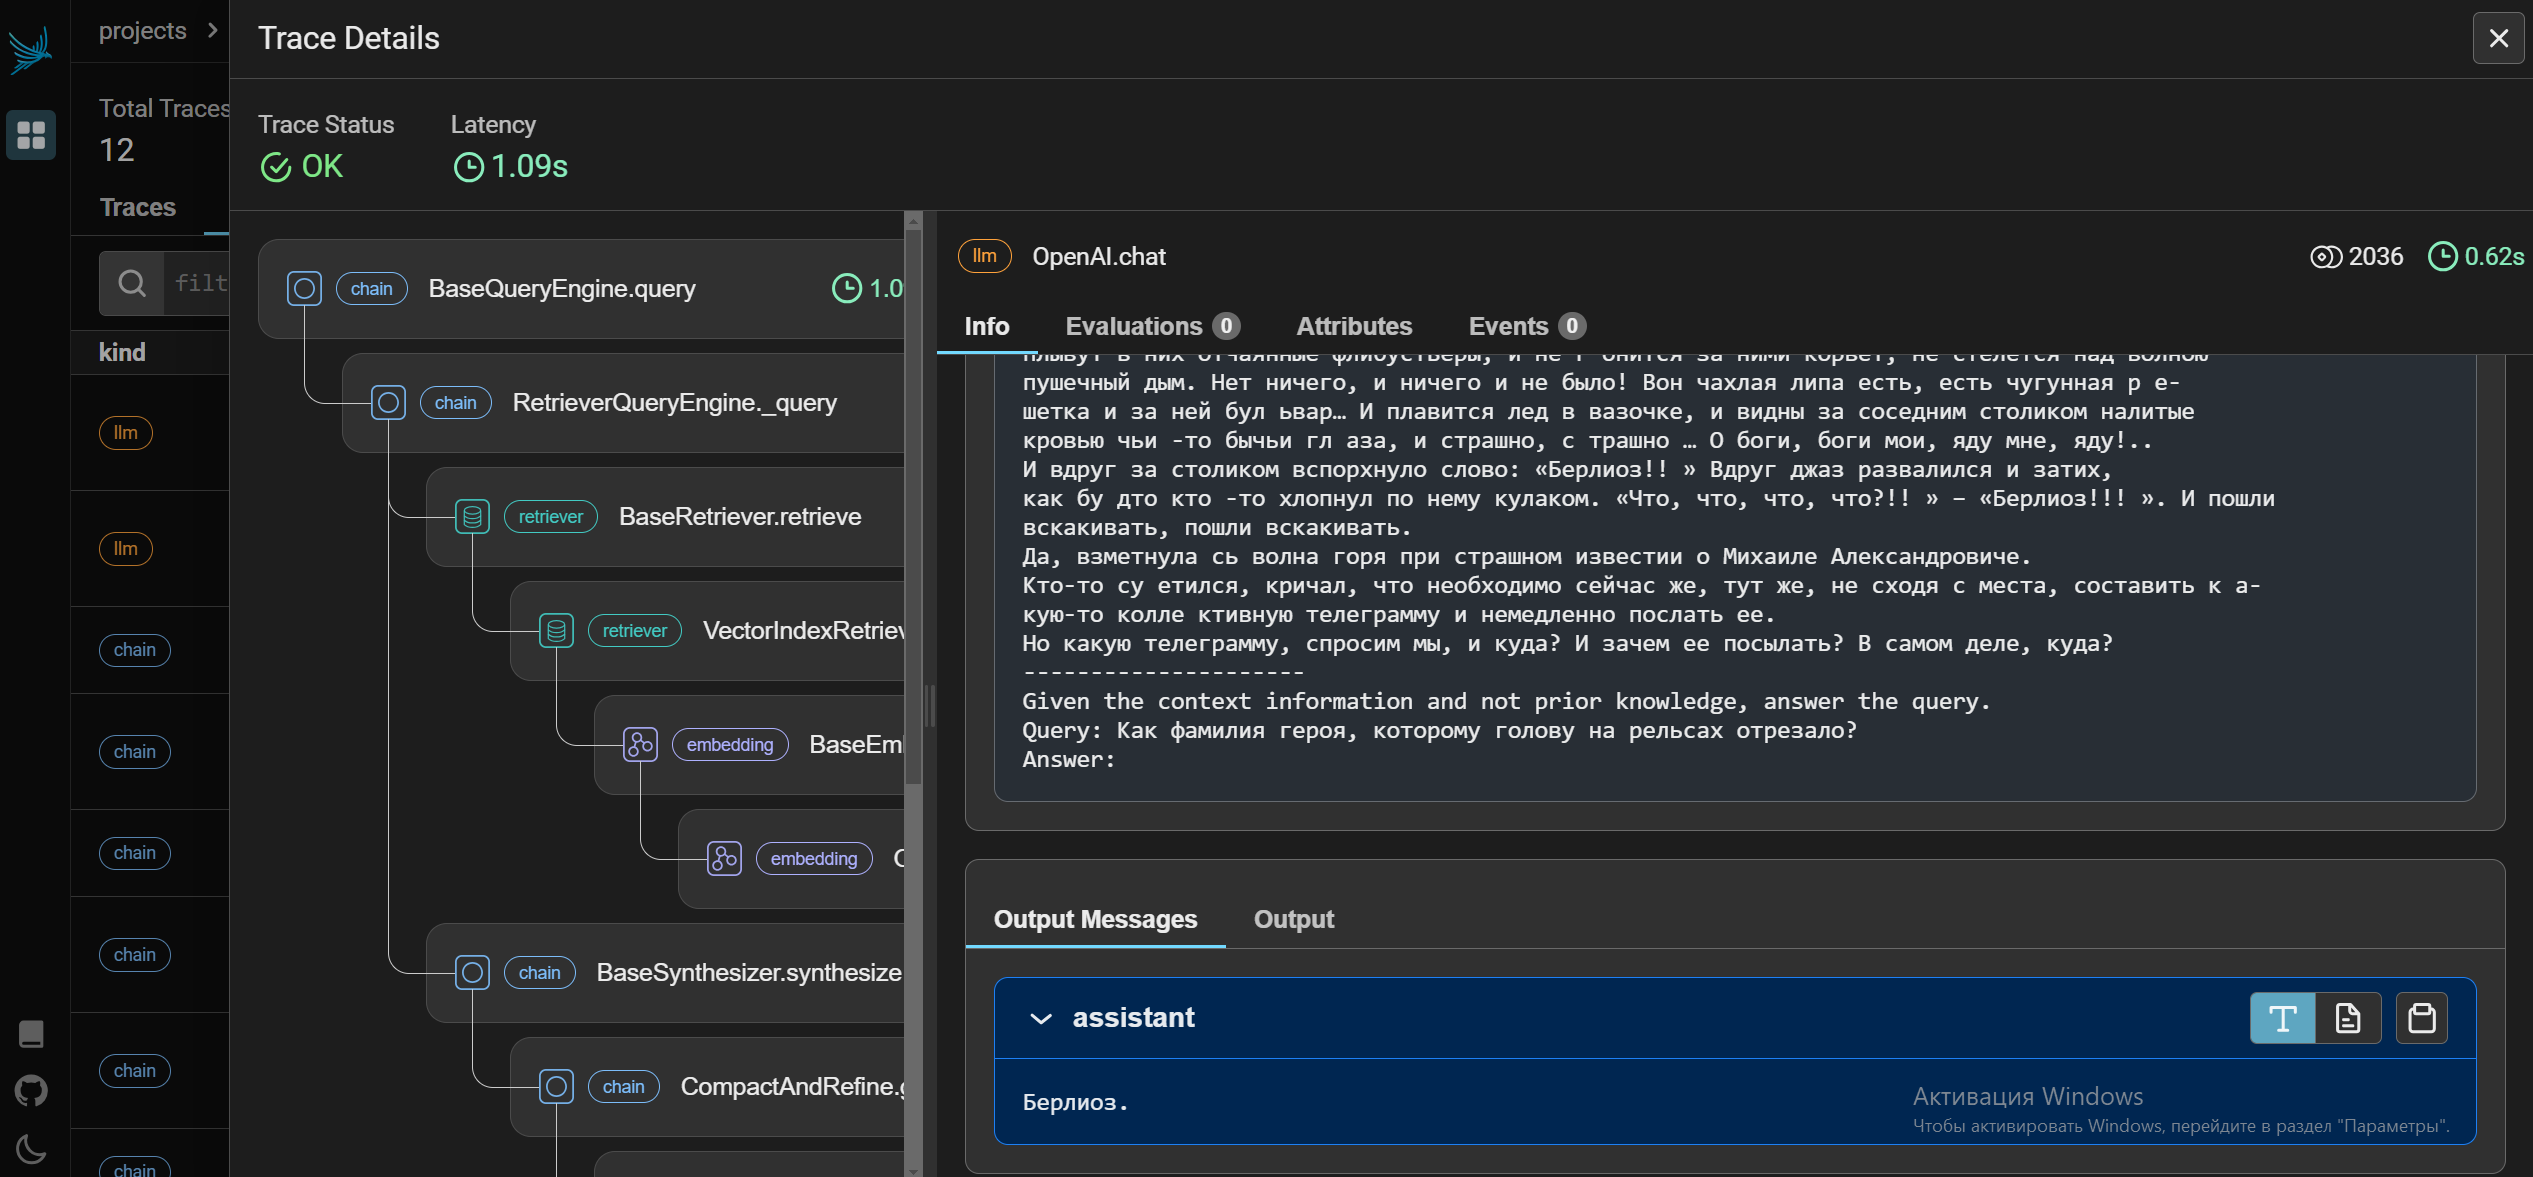

###Вывод

Модель 'gpt-3.5-turbo' отработала хорошо был выбран нужный контент из которого нужная информация была предоставленна в виде правдивого ответа. Я считаю что в данной работе галлюцинации модели не произошло.